In [1]:
import numpy as np
import pandas as pd
import re

df1 = pd.read_csv('raw_data/by economic activity by age by sex.csv')
df_economic_age_sex = df1.dropna().to_numpy()
print(df_economic_age_sex.shape)
geography_name_code = df_economic_age_sex[:,:3]
clean_df_economic_age_sex = df_economic_age_sex[:,3:]
print(geography_name_code.shape)
print(clean_df_economic_age_sex.shape)

df2 = pd.read_csv('raw_data/by economic activity by migration.csv')
df_migration_economic = df2.dropna().to_numpy()
print(df_migration_economic.shape)
clean_df_migration_economic = df_migration_economic[:,3:]
print(clean_df_migration_economic.shape)

df3 = pd.read_csv('raw_data/hours worked by age by sex by full or part time job type.csv')
df_worked_hours = df3.dropna().to_numpy()
print(df_worked_hours.shape)
clean_df_worked_hours = df_worked_hours[:,3:]
print(clean_df_worked_hours.shape)

df4 = pd.read_csv('raw_data/Provision of unpaid care by general health by sex by age.csv')
df_unpaid_care_hours = df4.dropna().to_numpy()
print(df_unpaid_care_hours.shape)
clean_df_unpaid_care_hours = df_unpaid_care_hours[:,3:]
print(clean_df_unpaid_care_hours.shape)

all_data = np.hstack((clean_df_economic_age_sex,clean_df_migration_economic,clean_df_worked_hours,clean_df_unpaid_care_hours))
print(all_data.shape)


(348, 627)
(348, 3)
(348, 624)
(348, 183)
(348, 180)
(348, 276)
(348, 273)
(348, 363)
(348, 360)
(348, 1437)


Because we need visualize the projected data in Tableau. We have two options to implement. The First option is to use Bayesian inference to determine the optimal number of components, then in Tableau, we use two dropdown boxes to let users choose X axis and Y axis for checking the data points' local structure in low dimensional space. The second way is to reduce the dimension to 2, no matter what methods are adopted. Although more information will be lost, but we can view the global structure after the dimension reduction. 

But After a while, I suddenly realized maybe the first option is meaningless for the exploration of the similarity between districts in the situation regarding the economical activities, hours worked, unpaid care hours and migration. Simply looking at the structure of data points on two of N (more than 2) components cannot help us obtain valuable insights. So, we should just reduce the dimensions to 2. 

Before dimensionality reduction, in terms of the issues I am researching, I should label each data point (districts) by calculating the ageing indicator, where the area with it which is more than 0.3 is ageing districts.

In [2]:
df_age = pd.read_csv("../data cleaning/raw_data/sex by age by LAD.csv")
numold = df_age["Age: Age 85 and over; Sex: All persons; measures: Value"].to_numpy()
for i in range(65, 85, 5):
    numold = numold + \
        df_age[f"Age: Age {i} to {i+4}; Sex: All persons; measures: Value"].to_numpy()
numTeenandAdult = df_age["Age: Age 16 to 19; Sex: All persons; measures: Value"].to_numpy()
for i in range(20, 65, 5):
    numTeenandAdult = numTeenandAdult + \
        df_age[f"Age: Age {i} to {i+4}; Sex: All persons; measures: Value"].to_numpy()
OldAgeDependencyRatio = numold/numTeenandAdult
print(OldAgeDependencyRatio[:5])

numEmployed = df1["Sex: All persons; Age: All categories: Age 16 and over; Economic Activity: Economically active: In employment: Total; measures: Value"].to_numpy()
realElderlyDependencyRatio = numold/numEmployed
print(realElderlyDependencyRatio[:5])
print(df1["geography"][:5])


[0.26455367 0.30410833 0.28280921 0.21419222 0.35579357]
[0.37600325 0.40165256 0.41104133 0.38284377 0.42402944]
0        Darlington
1     County Durham
2        Hartlepool
3     Middlesbrough
4    Northumberland
Name: geography, dtype: object


In [3]:
youngorOld = []
old_area_num = 0
young_area_num = 0
for i in realElderlyDependencyRatio:
    if i <0.3:
        youngorOld.append(0)
        young_area_num = young_area_num+1
    else:
        youngorOld.append(1)
        old_area_num = old_area_num+1

print(young_area_num)
print(old_area_num)


68
280


IF we want to data dimension to a levle to visualize, I think UMAP and tSNE would be optimal choice. But for tSNE, as the paper said, I used the recommedation nethod which is to apply PCA to decrease the dimension to 50 firstly and then aplly tSNE. The following will compare the results of UMAP with tSNE. 

Besides, LDA also deserves to try because it is a supervised method to reduce dimensions. And I have labels for each data points. But the biggest problem of it is that the number of components must be less than min(n_features, n_classes - 1), which means in my situation, the reduced components number is only 1.

In [4]:
import umap
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


RS = 1729
reducer = umap.UMAP(random_state=RS)
reducer.fit(clean_df_economic_age_sex)
embedding1_umap = reducer.transform(clean_df_economic_age_sex)
 
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(clean_df_economic_age_sex)
embedding1_tsne = TSNE(random_state=RS, learning_rate = 200).fit_transform(pca_result_50)

clf = LinearDiscriminantAnalysis()
projX = clf.fit_transform(clean_df_economic_age_sex, youngorOld)
embedding1_lda = []
for i in projX:
    embedding1_lda.append(i[0])
embedding1_lda = np.array(list(zip(embedding1_lda,list(np.zeros(len(embedding1_lda))))))

C:\Users\12055\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'LDA')

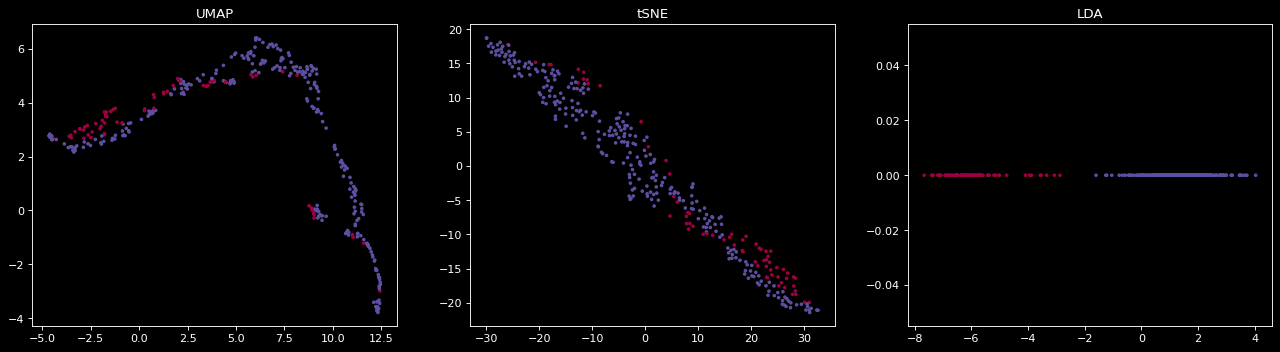

In [251]:
plt.figure(figsize=(20,5), dpi=80)
ax1 = plt.subplot(131)
ax1.scatter(embedding1_umap[:, 0], embedding1_umap[:, 1], c=youngorOld, cmap='Spectral',s=5)
ax1.set_title('UMAP')
ax2 = plt.subplot(132)
ax2.scatter(embedding1_tsne[:, 0], embedding1_tsne[:, 1], c=youngorOld, cmap='Spectral',s=5)
ax2.set_title('tSNE')
ax2 = plt.subplot(133)
ax2.scatter(embedding1_lda[:,0], embedding1_lda[:,1] ,c=youngorOld, cmap='Spectral',s=5)
ax2.set_title('LDA')

In [252]:
reducer = umap.UMAP(random_state=RS)
reducer.fit(clean_df_migration_economic)
embedding2_umap = reducer.transform(clean_df_migration_economic)

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(clean_df_migration_economic)
embedding2_tsne = TSNE(random_state=RS, learning_rate = 200).fit_transform(pca_result_50)

clf = LinearDiscriminantAnalysis()
projX = clf.fit_transform(clean_df_migration_economic, youngorOld)
embedding2_lda = []
for i in projX:
    embedding2_lda.append(i[0])
embedding2_lda = np.array(list(zip(embedding2_lda,list(np.zeros(len(embedding2_lda))))))

C:\Users\12055\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'LDA')

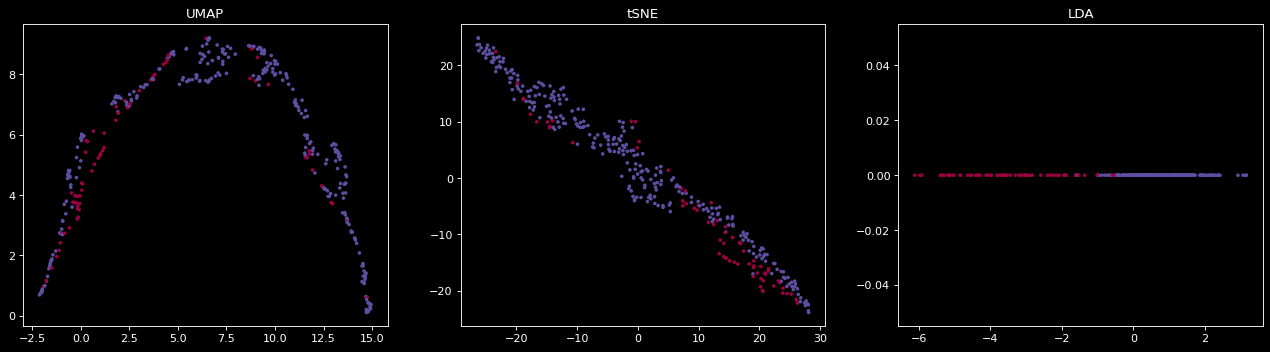

In [253]:
plt.figure(figsize=(20,5), dpi=80)
ax1 = plt.subplot(131)
ax1.scatter(embedding2_umap[:, 0], embedding2_umap[:, 1], c=youngorOld, cmap='Spectral',s=5)
ax1.set_title('UMAP')
ax2 = plt.subplot(132)
ax2.scatter(embedding2_tsne[:, 0], embedding2_tsne[:, 1], c=youngorOld, cmap='Spectral',s=5)
ax2.set_title('tSNE')
ax2 = plt.subplot(133)
ax2.scatter(embedding2_lda[:,0], embedding2_lda[:,1] ,c=youngorOld, cmap='Spectral',s=5)
ax2.set_title('LDA')

C:\Users\12055\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'LDA')

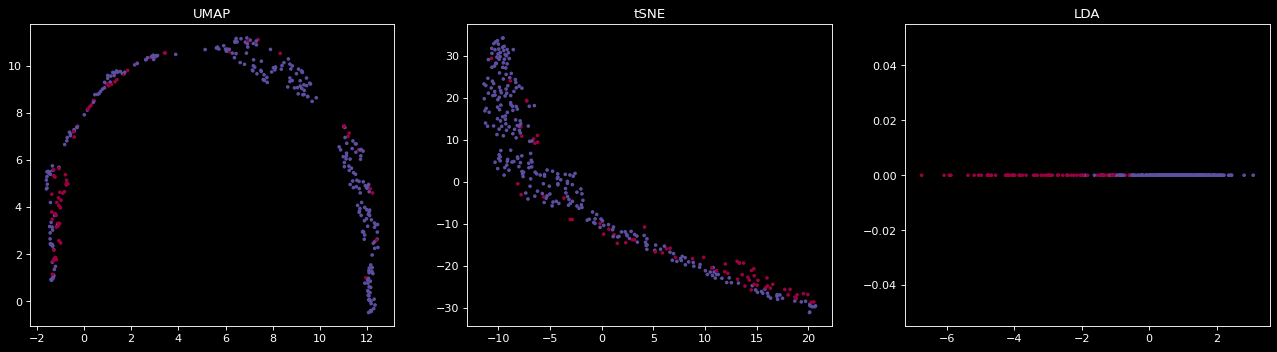

In [254]:
reducer = umap.UMAP(random_state=RS)
reducer.fit(clean_df_worked_hours)
embedding3_umap = reducer.transform(clean_df_worked_hours)

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(clean_df_worked_hours)
embedding3_tsne = TSNE(random_state=RS, learning_rate = 200).fit_transform(pca_result_50)

clf = LinearDiscriminantAnalysis()
projX = clf.fit_transform(clean_df_worked_hours, youngorOld)
embedding3_lda = []
for i in projX:
    embedding3_lda.append(i[0])
embedding3_lda = np.array(list(zip(embedding3_lda,list(np.zeros(len(embedding3_lda))))))

plt.figure(figsize=(20,5), dpi=80)
ax1 = plt.subplot(131)
ax1.scatter(embedding3_umap[:, 0], embedding3_umap[:, 1], c=youngorOld, cmap='Spectral',s=5)
ax1.set_title('UMAP')
ax2 = plt.subplot(132)
ax2.scatter(embedding3_tsne[:, 0], embedding3_tsne[:, 1], c=youngorOld, cmap='Spectral',s=5)
ax2.set_title('tSNE')
ax2 = plt.subplot(133)
ax2.scatter(embedding3_lda[:,0], embedding3_lda[:,1] ,c=youngorOld, cmap='Spectral',s=5)
ax2.set_title('LDA')

C:\Users\12055\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'LDA')

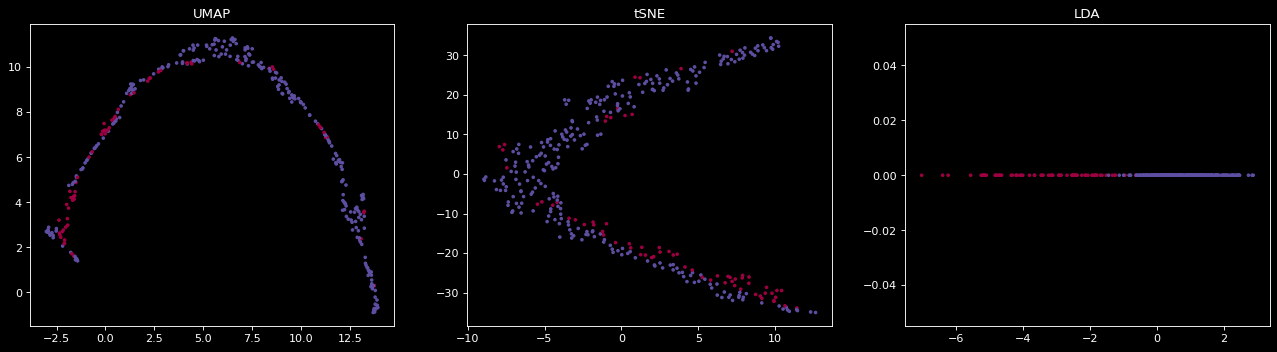

In [257]:
reducer = umap.UMAP(random_state=RS)
reducer.fit(clean_df_unpaid_care_hours)
embedding4_umap = reducer.transform(clean_df_unpaid_care_hours)

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(clean_df_unpaid_care_hours)
embedding4_tsne = TSNE(random_state=RS, learning_rate = 200).fit_transform(pca_result_50)

clf = LinearDiscriminantAnalysis()
projX = clf.fit_transform(clean_df_unpaid_care_hours, youngorOld)
embedding4_lda = []
for i in projX:
    embedding4_lda.append(i[0])
embedding4_lda = np.array(list(zip(embedding4_lda,list(np.zeros(len(embedding4_lda))))))

plt.figure(figsize=(20,5), dpi=80)
ax1 = plt.subplot(131)
ax1.scatter(embedding4_umap[:, 0], embedding4_umap[:, 1], c=youngorOld, cmap='Spectral',s=5)
ax1.set_title('UMAP')
ax2 = plt.subplot(132)
ax2.scatter(embedding4_tsne[:, 0], embedding4_tsne[:, 1], c=youngorOld, cmap='Spectral',s=5)
ax2.set_title('tSNE')
ax2 = plt.subplot(133)
ax2.scatter(embedding4_lda[:,0], embedding4_lda[:,1] ,c=youngorOld, cmap='Spectral',s=5)
ax2.set_title('LDA')

C:\Users\12055\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'LDA')

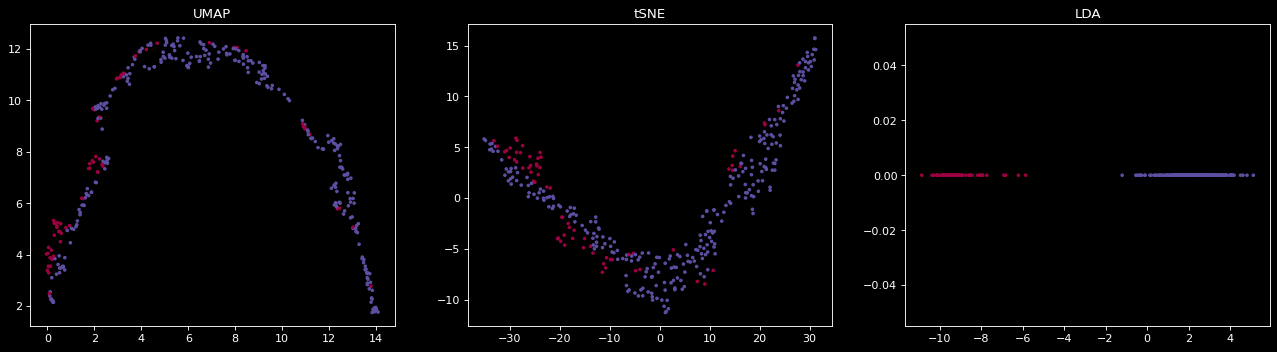

In [259]:
reducer = umap.UMAP(random_state=RS)
reducer.fit(all_data)
embedding5_umap = reducer.transform(all_data)

pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(all_data)
embedding5_tsne = TSNE(random_state=RS, learning_rate = 200).fit_transform(pca_result_50)

clf = LinearDiscriminantAnalysis()
projX = clf.fit_transform(all_data, youngorOld)
embedding5_lda = []
for i in projX:
    embedding5_lda.append(i[0])
embedding5_lda = np.array(list(zip(embedding5_lda,list(np.zeros(len(embedding5_lda))))))

plt.figure(figsize=(20,5), dpi=80)
ax1 = plt.subplot(131)
ax1.scatter(embedding5_umap[:, 0], embedding5_umap[:, 1], c=youngorOld, cmap='Spectral',s=5)
ax1.set_title('UMAP')
ax2 = plt.subplot(132)
ax2.scatter(embedding5_tsne[:, 0], embedding5_tsne[:, 1], c=youngorOld, cmap='Spectral',s=5)
ax2.set_title('tSNE')
ax2 = plt.subplot(133)
ax2.scatter(embedding5_lda[:,0], embedding5_lda[:,1] ,c=youngorOld, cmap='Spectral',s=5)
ax2.set_title('LDA')

For decreasing tableau data requesting time, some calculation fields will be computed here. 

In [271]:
totalnum_25to64 = df3[f"Sex: All persons; Age: Age 25 to 29; Hours Worked: All categories: Hours worked; measures: Value"]
for i in range(30, 65, 5):
    totalnum_25to64 = totalnum_25to64 + \
        df3[f"Sex: All persons; Age: Age {i} to {i+4}; Hours Worked: All categories: Hours worked; measures: Value"]
worked_hoursless15 = df3[f"Sex: All persons; Age: Age 25 to 29; Hours Worked: Part-time: 15 hours or less worked; measures: Value"]*7.5
for i in range(30, 65, 5):
    worked_hoursless15 = worked_hoursless15 + \
        df3[f"Sex: All persons; Age: Age {i} to {i+4}; Hours Worked: Part-time: 15 hours or less worked; measures: Value"]*7.5
worked_hours1630 = df3[f"Sex: All persons; Age: Age 25 to 29; Hours Worked: Part-time: 16 to 30 hours worked; measures: Value"] * \
    ((30-16)/2+16)
for i in range(30, 65, 5):
    worked_hours1630 = worked_hours1630 + \
        df3[f"Sex: All persons; Age: Age {i} to {i+4}; Hours Worked: Part-time: 16 to 30 hours worked; measures: Value"]*(
            (30-16)/2+16)
worked_hours3148 = df3[f"Sex: All persons; Age: Age 25 to 29; Hours Worked: Full-time: 31 to 48 hours worked; measures: Value"] * \
    ((48-31)/2+31)
for i in range(30, 65, 5):
    worked_hours3148 = worked_hours3148 + \
        df3[f"Sex: All persons; Age: Age {i} to {i+4}; Hours Worked: Full-time: 31 to 48 hours worked; measures: Value"]*(
            (48-31)/2+31)
worked_hoursmore49 = df3[f"Sex: All persons; Age: Age 25 to 29; Hours Worked: Full-time: 49 or more hours worked; measures: Value"]*(
    49+7.5)
for i in range(30, 65, 5):
    worked_hoursmore49 = worked_hoursmore49 + \
        df3[f"Sex: All persons; Age: Age {i} to {i+4}; Hours Worked: Full-time: 49 or more hours worked; measures: Value"]*(
            49+7.5)
average_hoursworked = (worked_hoursless15+worked_hours1630 +
                       worked_hours3148+worked_hoursmore49)/totalnum_25to64
print(average_hoursworked[:5])

0    36.259000
1    36.425312
2    35.457124
3    34.957391
4    36.310722
dtype: float64


In [277]:
labour_participatation_rate = df1["Sex: All persons; Age: All categories: Age 16 and over; Economic Activity: Economically active: Total; measures: Value"] / \
    df1["Sex: All persons; Age: All categories: Age 16 and over; Economic Activity: All categories: Economic activity; measures: Value"]

In [288]:
new_columns = ["date", "geography", "grography code",
               "Old-Age Dependency Ratio (OADR)", "Real Elderly Dependency Ratio (REDR)", "labour participatation rate", "average worked hours for 24 to 65",
               "economic age sex umap1", "economic age sex umap2", "economic age sex tsne1", "economic age sex tsne2", "economic age sex lda1", "economic age sex lda2",
               "migration umap1", "migration umap2", "migration tsne1", "migration tsne2", "migration lda1", "migration lda2",
               "worked hours umap1", "worked hours umap2", "worked hours tsne1", "worked hours tsne2", "worked hours lda1", "worked hours lda2",
               "unpaid hours umap1", "unpaid hours umap2", "unpaid hours tsne1", "unpaid hours tsne2", "unpaid hours lda1", "unpaid hours lda2",
               "overall umap1", "overall umap2", "overall tsne1", "overall tsne2", "overall lda1", "overall lda2"]
new_data = np.column_stack((geography_name_code, OldAgeDependencyRatio, realElderlyDependencyRatio,
                      labour_participatation_rate, average_hoursworked,
                     embedding1_umap, embedding1_tsne, embedding1_lda,
                     embedding2_umap, embedding2_tsne, embedding2_lda,
                     embedding3_umap, embedding3_tsne, embedding3_lda,
                     embedding4_umap, embedding4_tsne, embedding4_lda,
                     embedding5_umap, embedding5_tsne, embedding5_lda))
print(new_data.shape)
new_df=pd.DataFrame(data=new_data,columns=new_columns)
new_df.to_csv(path_or_buf="clean_data/data proection and calculation.csv", index = False)

(348, 37)


In [ ]:
new_columns = ["date", "geography", "grography code",
               "Old-Age Dependency Ratio (OADR)", "Real Elderly Dependency Ratio (REDR)", "labour participatation rate", "average worked hours for 24 to 65",
               "economic age sex umap1", "economic age sex umap2", "economic age sex tsne1", "economic age sex tsne2", "economic age sex lda1", "economic age sex lda2",
               "migration umap1", "migration umap2", "migration tsne1", "migration tsne2", "migration lda1", "migration lda2",
               "worked hours umap1", "worked hours umap2", "worked hours tsne1", "worked hours tsne2", "worked hours lda1", "worked hours lda2",
               "unpaid hours umap1", "unpaid hours umap2", "unpaid hours tsne1", "unpaid hours tsne2", "unpaid hours lda1", "unpaid hours lda2",
               "overall umap1", "overall umap2", "overall tsne1", "overall tsne2", "overall lda1", "overall lda2"]
new_data = np.column_stack((geography_name_code, OldAgeDependencyRatio, realElderlyDependencyRatio,
                      labour_participatation_rate, average_hoursworked,
                     embedding1_umap, embedding1_tsne, embedding1_lda,
                     embedding2_umap, embedding2_tsne, embedding2_lda,
                     embedding3_umap, embedding3_tsne, embedding3_lda,
                     embedding4_umap, embedding4_tsne, embedding4_lda,
                     embedding5_umap, embedding5_tsne, embedding5_lda))
print(new_data.shape)
new_df=pd.DataFrame(data=new_data,columns=new_columns)
new_df.to_csv(path_or_buf="clean_data/data proection and calculation.csv", index = False)

(348, 37)
